In [12]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/Dropbox/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



In [2]:
data_dir = '/Users/gbromley/Dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.tmp.dat.nc'
#vap_file = 'vap/cru_ts3.24.1901.2015.vap.dat.nc'
#nc_vap = xr.open_dataset(data_dir+vap_file)
nc_temp = xr.open_dataset(data_dir+temp_file)


In [3]:
t2m = nc_temp['tmp']
ngp_mask = xr.open_dataset('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/ngp_mask.nc')
ngp_mask = ngp_mask.rename({'__xarray_dataarray_variable__':'ngp'})
mask = ngp_mask['ngp']

In [4]:
#t_season='AMJ'
#t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2016-01-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
#t2m = t2m.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#mask = mask.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [5]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))


#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))

#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_30.groupby('time.month').mean(dim='time')

In [6]:
t2m_new = t2m_slice.groupby('time.month').apply(lambda x: x.groupby('time.year').mean(dim='time'))

In [7]:
#create 2d structure to hold slope
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
lat = t2m.lat
lon=t2m.lon
vals = np.empty(shape=(12,len(lat),len(lon)))
vals[:,:,:] = np.nan
spatial_trend = xr.DataArray(vals,coords=[month,lat,lon],dims=['month','lat','lon'])
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#spatial_trend = xr.DataArray(np.random.rand(4,54,76),coords=[season,lat,lon],dims=['season','lat','lon'])


slope_scipy = t2m.isel(time=1).copy(deep=True)
#create 2d structure to hold pvalues
lat = t2m.lat
lon=t2m.lon
pvalues = xr.DataArray(np.random.rand(12,len(lat),len(lon)),coords=[month,lat,lon],dims=['month','lat','lon'])
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [13]:
anom = t2m_new - t2m_clim_months_avg

In [14]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(anom.year))
corr_vals = sm.add_constant(corr_vals)
for k in np.arange(0,12):
    for i in np.arange(0,len(anom['lat'])):
        for j in np.arange(0,len(anom['lon'])):
            series = anom[k,i,j,:]
            model = sm.OLS(series.values,corr_vals)
            #ac_coe = sm.tsa.stattools.acf(series.values)
            #model = sm.OLS(series.values,corr_vals)
            #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
            results = model.fit()
            slope = results.params[1]
            #adjusted_error = results.bse[1] * (np.sqrt((1-ac_coe[1])/(1+ac_coe[1])))
            #t_value = ((slope)/adjusted_error)
            #tw0-sided
           # p_value = 2*(1-stats.t.cdf(abs(t_value), results.df_resid))
            #t_value = ((slope - 0.02)/results.bse[1])
            #p_value = stats.t.cdf(t_value, results.df_resid)
            #p_value = stats.t.sf(results.tvalues[0], results.df_resid)
            spatial_trend[k,i,j]=slope*10
            #slope_scipy[i,j] = slope_2*10
            #pvalues[k,i,j]= p_value

In [9]:
spatial_trend

<xarray.DataArray 't2m_trend' (month: 12, lat: 360, lon: 720)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * month    (month) <U9 'January' 'February' 'March' 'April' 'May' 'June' ...
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float32 -179.75 -179.25 -178.75 -178.25 -177.75 -177.25 ...
Attributes:
    units:      C per Decade
    long_nam

In [ ]:
pvals = pvalues.where(pvalues.values < 0.05)

In [13]:
#create 2d data in ngp
ngp = spatial_trend.where(mask==1)
test = ngp.stack(z=('lat','lon'))
#
season_values = test.groupby('month').apply(lambda x: x.dropna(dim='z'))

#create 2d data over globe
global_trends = spatial_trend.stack(z=('lat','lon'))

glob_seasonal_trends = global_trends.groupby('month').apply(lambda x: x.dropna(dim='z'))

#save data
glob_data = glob_seasonal_trends.reset_index('z')
ngp_data = season_values.reset_index('z')

glob_data.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/global_monthly_temp_trends.nc')
ngp_data.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/ngp_monthly_temp_trends.nc')

In [86]:
ngp_data = season_values.reset_index('z')
ngp_data.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/ngp_monthly_temp_trends.nc')

In [76]:
test_month = 'July'
month = season_values.sel(month=test_month)

month = month.to_masked_array(copy=True)

In [42]:
print(str(np.mean(month))+ "+/-" + str(np.std(month)))
#np.std(month)

0.1840439128355836+/-0.09842229565292338


(array([  7.,  24.,  70.,  65.,  81.,  92., 132.,  73.,  56.,  36.]),
 array([-0.06623499, -0.02126429,  0.02370641,  0.06867711,  0.11364781,
         0.15861851,  0.20358921,  0.24855991,  0.29353061,  0.33850131,
         0.38347201]),
 <a list of 10 Patch objects>)

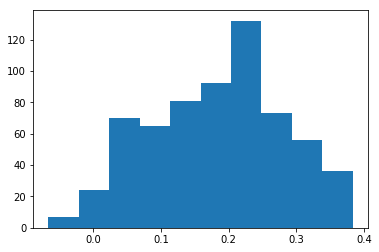

In [43]:
plt.hist(month)

In [44]:
global_trends = spatial_trend.stack(z=('lat','lon'))


glob_seasonal_trends = global_trends.groupby('month').apply(lambda x: x.dropna(dim='z'))

In [46]:
glob_month = glob_seasonal_trends.sel(month=test_month).to_masked_array(copy=True)

In [56]:

test2 = glob_seasonal_trends.reset_index('z')

In [57]:
test2.to_netcdf('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/global_monthly_temp_trends.nc')

In [79]:
bplot_stats = np.full((12,5), np.nan)

In [106]:
np.savetxt("/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/global_december_trends.csv",glob,delimiter=',')
np.savetxt("/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/Data/ngp_december_trends.csv",ngp,delimiter=',')

In [101]:
for month in range(0,12):
    glob = glob_seasonal_trends.isel(month = month).to_masked_array(copy=True)
    ngp = season_values.isel(month = month).to_masked_array(copy=True)
    tstat, pval = stats.ks_2samp(ngp,glob)
    bplot_stats[month] = np.mean(glob), np.std(glob), np.mean(ngp), np.std(ngp), pval

In [102]:
bplot_stats[:,0], bplot_stats[:,2]

(array([0.34503527, 0.32643327, 0.35560778, 0.33673307, 0.2867272 ,
        0.29012698, 0.25096697, 0.2611349 , 0.2747594 , 0.37210399,
        0.38483428, 0.33923661]),
 array([ 0.90931646, -0.06275393,  0.26975499,  0.00423321, -0.17491947,
        -0.12552426,  0.18404391,  0.10443995,  0.45647035,  0.03377085,
         0.32588798,  0.42265335]))

In [103]:
bplot_stats[:,4]

array([0.00000000e+000, 7.63155364e-296, 2.79387031e-051, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 8.57392687e-031, 5.16155130e-232,
       1.30775650e-186, 0.00000000e+000, 4.57901275e-048, 4.67881932e-051])

In [100]:
stats.ks_2samp(ngp,glob)

Ks_2sampResult(statistic=0.30266637934733737, pvalue=4.678819321619939e-51)

In [78]:
sm.stats.weightstats.ztest(month, glob_month)

(-10.91769685965668, 9.487103993437276e-28)

In [ ]:
plt.rcParams.update({'font.size': 22})
month = ['J','F','M','A','M','J','J','A','S','O','N','D']
fig, ax = plt.subplots(ncols=1)
fig.set_dpi(400)
fig.set_size_inches((13,7))
pos = np.array(range(len(season_values))) + 1
plt.boxplot(season_values, positions=pos, linewidth=14)
plt.xticks([1, 2, 3,4,5,6,7,8,9,10,11,12], month)
ax.axhline(0)
ax.set_ylabel('Temperature Trend $^\circ$C / Decade')
plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/temp_trend_boxplots.png',bbox_inches='tight')


In [ ]:
spatial_trend[8,:,:]